<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">

# <p style="text-align: center;">Lab 4 (Weeks 8,9): Convolutional Neural Networks (CNNs)</p>
## <p style="text-align: center;">Notebook II: Applications</p>

<b>Enter you student details below</b>

- <b>Student Name:</b> Alexander Li
- <b>Student ID:</b> 30630711
   

<div class="alert alert-block alert-danger">

## Table of Contents
    
* [Libraries](#Libraries)

* [Task 3: Design and train a CNN by yourself on the FER-4 dataset and Analyse Results](#task_3)

* [Discussion Questions](#t3_1)

<div class="alert alert-block alert-warning">

# Libraries

In this lab, you will use several pytorch and pytorch lightning libraries along with several other basic python libraries. All the libraries that you need are given below.

In [1]:
## Libraries, you do not need to import any additional libraries for this lab

# If you run on Jupyter Lab uncomment bellow comment
# ! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics" "torchsummary"

# If you run on google colab uncomment bellow comment
#!pip install "pytorch-lightning" "torchmetrics" "torchsummary" -qq

import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import log_softmax, softmax
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
import torchmetrics
from torchsummary import summary

from IPython.display import display

import lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Global seed set to 4179


<div class="alert alert-block alert-warning">

# Facial Expression Recognition (FER) Dataset <a class="anchor" id="python-basics"></a>
    
For all the work in this notebook, you will be using the FER dataset.
    
<img src="https://production-media.paperswithcode.com/datasets/FER2013-0000001434-01251bb8_415HDzL.jpg" width="500" />
    
The FER dataset contains diverse grayscale images of 7 facial emotions classes: anger, disgust, fear, happiness, sadness, surprise, and neutrality. Each image is of size 48x48 pixels, enabling efficient processing. For simplicity, in this task you will be using a subset of the full dataset which only contains the four classes (0)happy, (1)neural, (2)sad, and (3)surprise. We will call this the **FER-4 dataset**.

<div class="alert alert-block alert-info">

# Task 3 - Design and train a CNN on the FER-4 dataset and Analyse Results <a class="anchor" id="task_3"></a>
        
In this task, we do not enforce any model architecture or hyper-parameters (only some recommendations). You will design a CNN for image classification task and train it on the FER-4 dataset. You will use PyTorch's inbuilt datasets class, and Pytorch Lightning's module class to construct a CNN in order to perform training on the FER-4 dataset. You should use the knowledge obtained from Task 1 to complete this task. 

Note that you may want to use *transforms.Grayscale(num_output_channels = 1)* to convert the .jpg images to grayscale tensors. You will also analyse the results on the test dataset using the knowledge obtained from Task 2.
    
**Final deliverables of this task will be the following:**
1. Accuracy of more than 65% on the test dataset.
2. Reasonably converging train/val loss/accuracy curves.
3. Confusion Matrix
4. Visualization of top 5 misclassified images for each of the four classes.
5. Visualization of the saliency map of a correctly predicted 'happy' image.
6. Use an image of yourself! Capture your image from the webcam/phone and test your model.

We have provided headings for where things should go, but feel free to add more to meet all the final deliverables!

### Let's take a quick look at the dataset

In [2]:
########################################################################
# DO NOT CHANGE

# Get a list of class names from the 'data/fer4/train' directory
class_names = os.listdir('data/fer4/train')

# Print the list of class names
print(f'class names: {class_names}')

# Calculate the number of classes by counting the elements in the 'class_names' list
num_classes = len(class_names)

# Print the number of classes
print(f'number of classes: {num_classes}')
########################################################################

class names: ['happy', 'neutral', 'sad', 'surprise']
number of classes: 4


### Define Transformations

In [7]:
########################################################################
# Do not change the transforms we have provided
# However, you can add other data augmentation techniques


train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (left to right)
    transforms.ToTensor(), # This is the transform we provide
    transforms.Grayscale(num_output_channels=1), # This is the transform we provide
    transforms.Resize([48,48]), # This is the transform we provide
    transforms.Normalize(0.5, 0.5), # This is the transform we provide
])


val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([48,48]),
    transforms.Normalize(0.5, 0.5),
])
########################################################################

### Create Datasets

In [8]:
########################################################################
# DO NOT CHANGE
trainset = torchvision.datasets.ImageFolder(root='data/fer4/train', transform=train_transforms)
trainset, valset = torch.utils.data.random_split(trainset, [0.7, 0.3])
testset = torchvision.datasets.ImageFolder(root='data/fer4/test', transform=val_test_transforms)

print('Image count for each set\n------------------------')
print(f'trainset\t: {len(trainset)}')
print(f'valset  \t: {len(valset)}')
print(f'testset \t: {len(testset)}')
########################################################################

Image count for each set
------------------------
trainset	: 14127
valset  	: 6054
testset 	: 5085


### Create Dataloaders

In [9]:
BATCH_SIZE = 256 # Define batch size

trainloader = DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False)
valloader = DataLoader(valset, shuffle=False, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False)
testloader = DataLoader(testset, shuffle=False, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False)

print('Batch shape for each loader\n---------------------------')
images, labels = next(iter(trainloader))
print(f'trainloader\t: {images.shape}')
images, labels = next(iter(valloader))
print(f'valloader  \t: {images.shape}')
images, labels = next(iter(testloader))
print(f'testloader \t: {images.shape}')

Batch shape for each loader
---------------------------


c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


trainloader	: torch.Size([256, 1, 48, 48])
valloader  	: torch.Size([256, 1, 48, 48])
testloader 	: torch.Size([256, 1, 48, 48])


### Visualize the dataset

Make sure you always get a feel for the dataset before you start applying models to it!

train set


c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


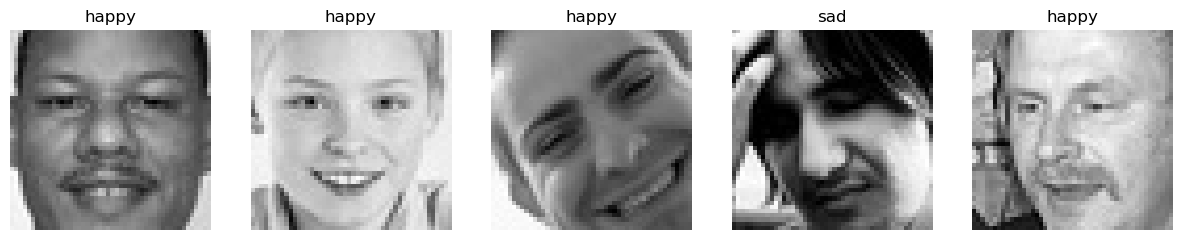

val set


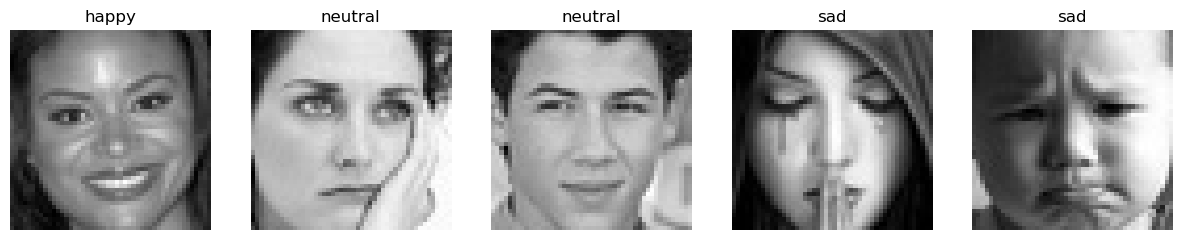

test set


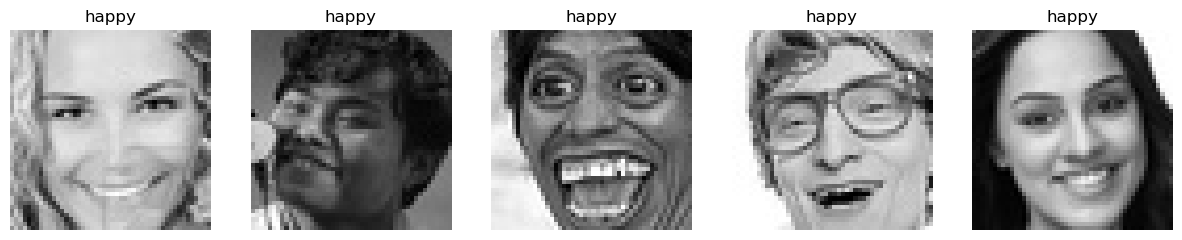

In [17]:
# Write a function to visualize images from a given data loader 
# Note: Use titles to denote class label in words.
def visualize_dataloader(dataloader, class_names):
    # Create a figure with subplots to display images
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    # Get a batch of images and labels from the data loader
    images, labels = next(iter(dataloader))

    # Loop through the first 5 images in the batch
    for i in range(5):
        image = images[i].squeeze()  # Un-normalize the image
        label = labels[i]  # Get the label for the image

        # Display the image in the subplot
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(class_names[label])
        axes[i].axis("off")

    # Show the plot with the images and labels
    plt.show()
    
# visualize images from the trainloader
print('train set')
visualize_dataloader(trainloader, class_names)

# visualize images from the valloader
print('val set')
visualize_dataloader(valloader, class_names)

# visualize images from the valloader
print('test set')
visualize_dataloader(testloader, class_names)

<div class="alert alert-block alert-info">

### Design your own CNN

Here are some guidelines in the CNN you can construct (you may stray away from this if you find other architectures are better):
- 4 convolutional layers
- Some (or all) of the convolutional layers can have pooling layers (this reduces size of feature maps well!)
- Test several activation functions (ReLU, sigmoid, tanh etc.) 
- Test different optimizers (SGD usually uses lr=0.1, ADAM usually uses lr=0.001, these are only guidelines and you can tweak the learning rates based on the datasets)

In [23]:
class MyCNN(pl.LightningModule):
    
    def __init__(self, num_classes):
        super().__init__()
        # Define layers of a CNN
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # fc
        self.fc = nn.Linear(128*3*3, num_classes)

        self.gap = nn.AdaptiveAvgPool2d(3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.loss_fn = nn.CrossEntropyLoss()

        # log
        self.train_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)


    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.gap(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

    def training_step(self, batch, batch_idx):
        # Define logic for training step
        # Define logic for training step
        x, y = batch
        logits = self(x)
        y_preds = logits.argmax(1)
        loss = self.loss_fn(logits, y)
        self.train_accuracy.update(y_preds, y)

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # Define logic for validation step
        x, y = batch
        logits = self(x)
        y_preds = logits.argmax(1)
        loss = self.loss_fn(logits, y)
        self.val_accuracy.update(y_preds, y)

        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc', self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # Define logic for test step
        x, y = batch
        logits = self(x)
        y_preds = logits.argmax(1)
        loss = self.loss_fn(logits, y)
        self.test_accuracy.update(y_preds, y)

        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
    def predict_step(self, batch, batch_idx):
        # Define logic for prediction step
        x, y = batch
        logits = self(x)
        #y_preds = logits.argmax(1)

        return logits, y, x # Return predicted class, actual class, and input 

    def configure_optimizers(self):
        # Configure optimizers and schedulers
        optimizer = torch.optim.SGD(self.parameters(), lr=0.08)
        
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader

    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

### Initialize the CNN

In [24]:
task3_model = MyCNN(num_classes) # intialize CNN

# print summary of the model to double check
summary(task3_model, (1, 48,48)) # delete .to('cuda') if not using cpu

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             160
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 24, 24]           4,640
              ReLU-5           [-1, 32, 24, 24]               0
         MaxPool2d-6           [-1, 32, 12, 12]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
           Conv2d-10            [-1, 128, 6, 6]          73,856
             ReLU-11            [-1, 128, 6, 6]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
AdaptiveAvgPool2d-13            [-1, 128, 3, 3]               0
             ReLU-14            [-1, 12

### Define progress bar and checkpoint callback functions 

In [25]:
# Define checkpoint callback function to save the model at the best epoch
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    save_top_k=1,        # save the best model based on validation accuracy
    mode="max",
    every_n_epochs=1
)

# Create customized progress bar theme 
progress_bar = RichProgressBar(refresh_rate=10, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

### Train the CNN

In [26]:
task3_trainer = pl.Trainer(accelerator = "auto",
                      #devices = 1 if torch.cuda.is_available() else None,
                      max_epochs = 100,
                      callbacks = [progress_bar, checkpoint_callback],
                      logger = CSVLogger("logs_task3")) # Call pl.Trainer and put in the relevant arguments

task3_trainer.fit(task3_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name           ┃ Type               ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ conv1          │ Conv2d             │    160 │
│ 1  │ conv2          │ Conv2d             │  4.6 K │
│ 2  │ conv3          │ Conv2d             │ 18.5 K │
│ 3  │ conv4          │ Conv2d             │ 73.9 K │
│ 4  │ fc             │ Linear             │  4.6 K │
│ 5  │ gap            │ AdaptiveAvgPool2d  │      0 │
│ 6  │ maxpool        │ MaxPool2d          │      0 │
│ 7  │ relu           │ ReLU               │      0 │
│ 8  │ loss_fn        │ CrossEntropyLoss   │      0 │
│ 9  │ train_accuracy │ MulticlassAccuracy │      0 │
│ 10 │ val_accuracy   │ MulticlassAccuracy │      0 │
│ 11 │ test_accuracy  │ MulticlassAccuracy │      0 │
└────┴────────────────┴────────────────────┴────────┘

Trainable params: 101 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 101 K                                                                                                
Total estimated model params size (MB): 0

Output()

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4
38: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


### Test the CNN

In [29]:
checkpoint_task3 = torch.load('logs_task3/lightning_logs/version_1/checkpoints/epoch=94-step=5320.ckpt')
task3_model.load_state_dict(checkpoint_task3['state_dict'])
task3_trainer.test(task3_model) 

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6666666865348816     │
│         test_loss         │    1.5932618379592896     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5932618379592896, 'test_acc': 0.6666666865348816}]

### Read logs

In [30]:
# metrics_task_3 = pd.read_csv('logs/task3/lightning_logs/version_0/metrics.csv')
metrics_task_3 = pd.read_csv(task3_trainer.logger.log_dir + "/metrics.csv")
metrics_task_3.set_index("epoch", inplace=True)
metrics_task_3 = metrics_task_3.groupby(level=0).sum().drop("step", axis=1) 

### Plot train and validation losses against epoch

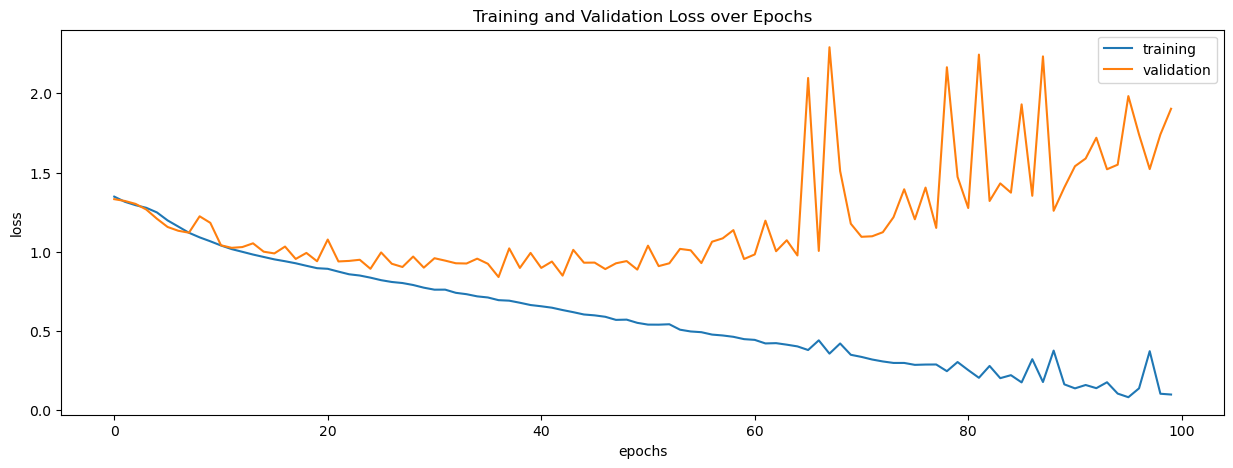

In [31]:
# Create a figure with all the appropriate labels/titles etc.
train_loss = metrics_task_3["train_loss"]
val_loss = metrics_task_3["val_loss"]
plt.figure(0, figsize=(15,5))
plt.plot(train_loss[:-1], label="training")
plt.plot(val_loss[:-1], label="validation")
#plt.xticks(ticks=range(len(val_loss)))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

### Plot train and validation accuracies against epoch

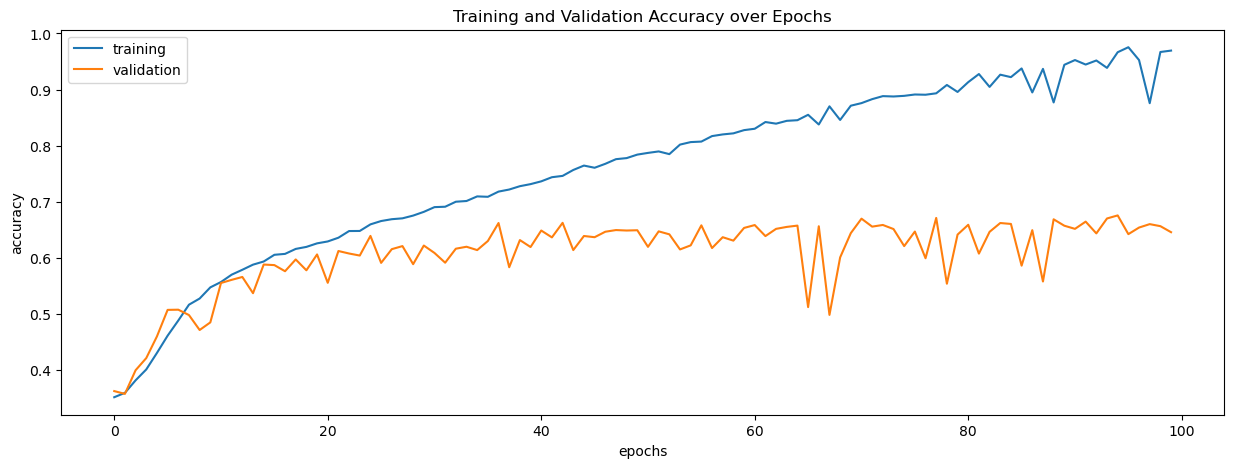

In [32]:
# Create a figure with all the appropriate labels/titles etc.
train_acc = metrics_task_3["train_acc"]
val_acc = metrics_task_3["val_acc"]
plt.figure(1, figsize=(15,5))
plt.plot(train_acc[:-1], label="training")
plt.plot(val_acc[:-1], label="validation")
#plt.xticks(ticks=range(len(val_loss)))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

### Get predictions for the test set for later use 

In [33]:
## These are the predictions for the test set. You will use this for the tasks below during the analysis process.

predictions = task3_trainer.predict(task3_model, testloader) # do not do anything to the variable 'predictions' you will reuse it

test_outputs = torch.concat([prediction[0] for prediction in predictions], dim=0)
test_labels = torch.concat([prediction[1] for prediction in predictions], dim=0)
test_inputs = torch.concat([prediction[2] for prediction in predictions], dim=0)
test_preds = test_outputs.argmax(dim=1)

Output()

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: 
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) 
will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress 
this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which 
means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use 
antialiasing). This also applies if you are using the inference transforms from the models weights: update the call
to weights.transforms(antialias=True).
  warnings.warn(

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


### Confusion Matrix

Ensure you use proportion instead of absolute value. Create the confusion matrix for the four classes.

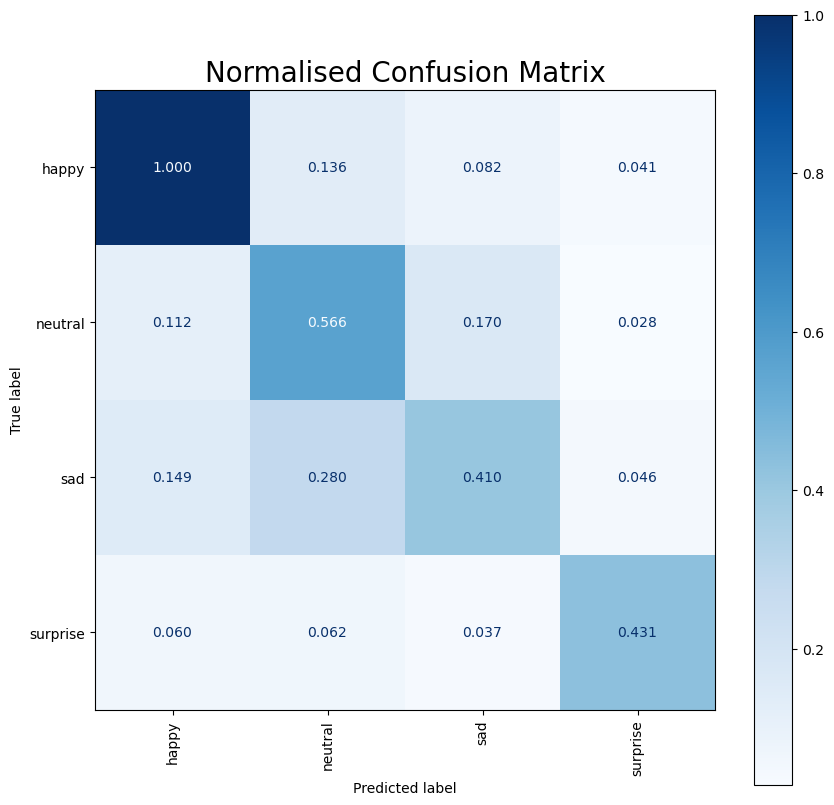

In [34]:
# Plot the confusion matrix
# You can create a ConfusionMatrix instance for multiclass classification with 'num_classes' from the lightning library
from torchmetrics import ConfusionMatrix
confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
task3_model.eval() # Set the model to evaluation mode
# Loop through all batches in the testloader and fill out the confusion matrix
with torch.no_grad():
    for batch in testloader:
        inputs, labels = batch
        logits = task3_model(inputs)
        preds = logits.argmax(dim=1)
        confusion_matrix.update(preds.cpu(), labels)

# print the confusion matrix
# print(confusion_matrix.compute())
conf_max_val = np.max(confusion_matrix.compute().numpy())
# confusion_matrix_np = confusion_matrix.compute().numpy() / conf_max_val

from sklearn.metrics import ConfusionMatrixDisplay

# Create a ConfusionMatrixDisplay object from the ConfusionMatrix instance
cm_display = ConfusionMatrixDisplay(confusion_matrix.compute().numpy() / conf_max_val, display_labels=class_names)

# Plot the confusion matrix, with large size
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Normalised Confusion Matrix", fontsize = 20)
cm_display.plot(cmap='Blues', xticks_rotation='vertical', values_format='.3f', ax=ax)


### Top Misclassified

You will only plot the top misclassified classes here. Please plot 5 images of each class (so 20 images in total). This will be similar to the basics notebook.

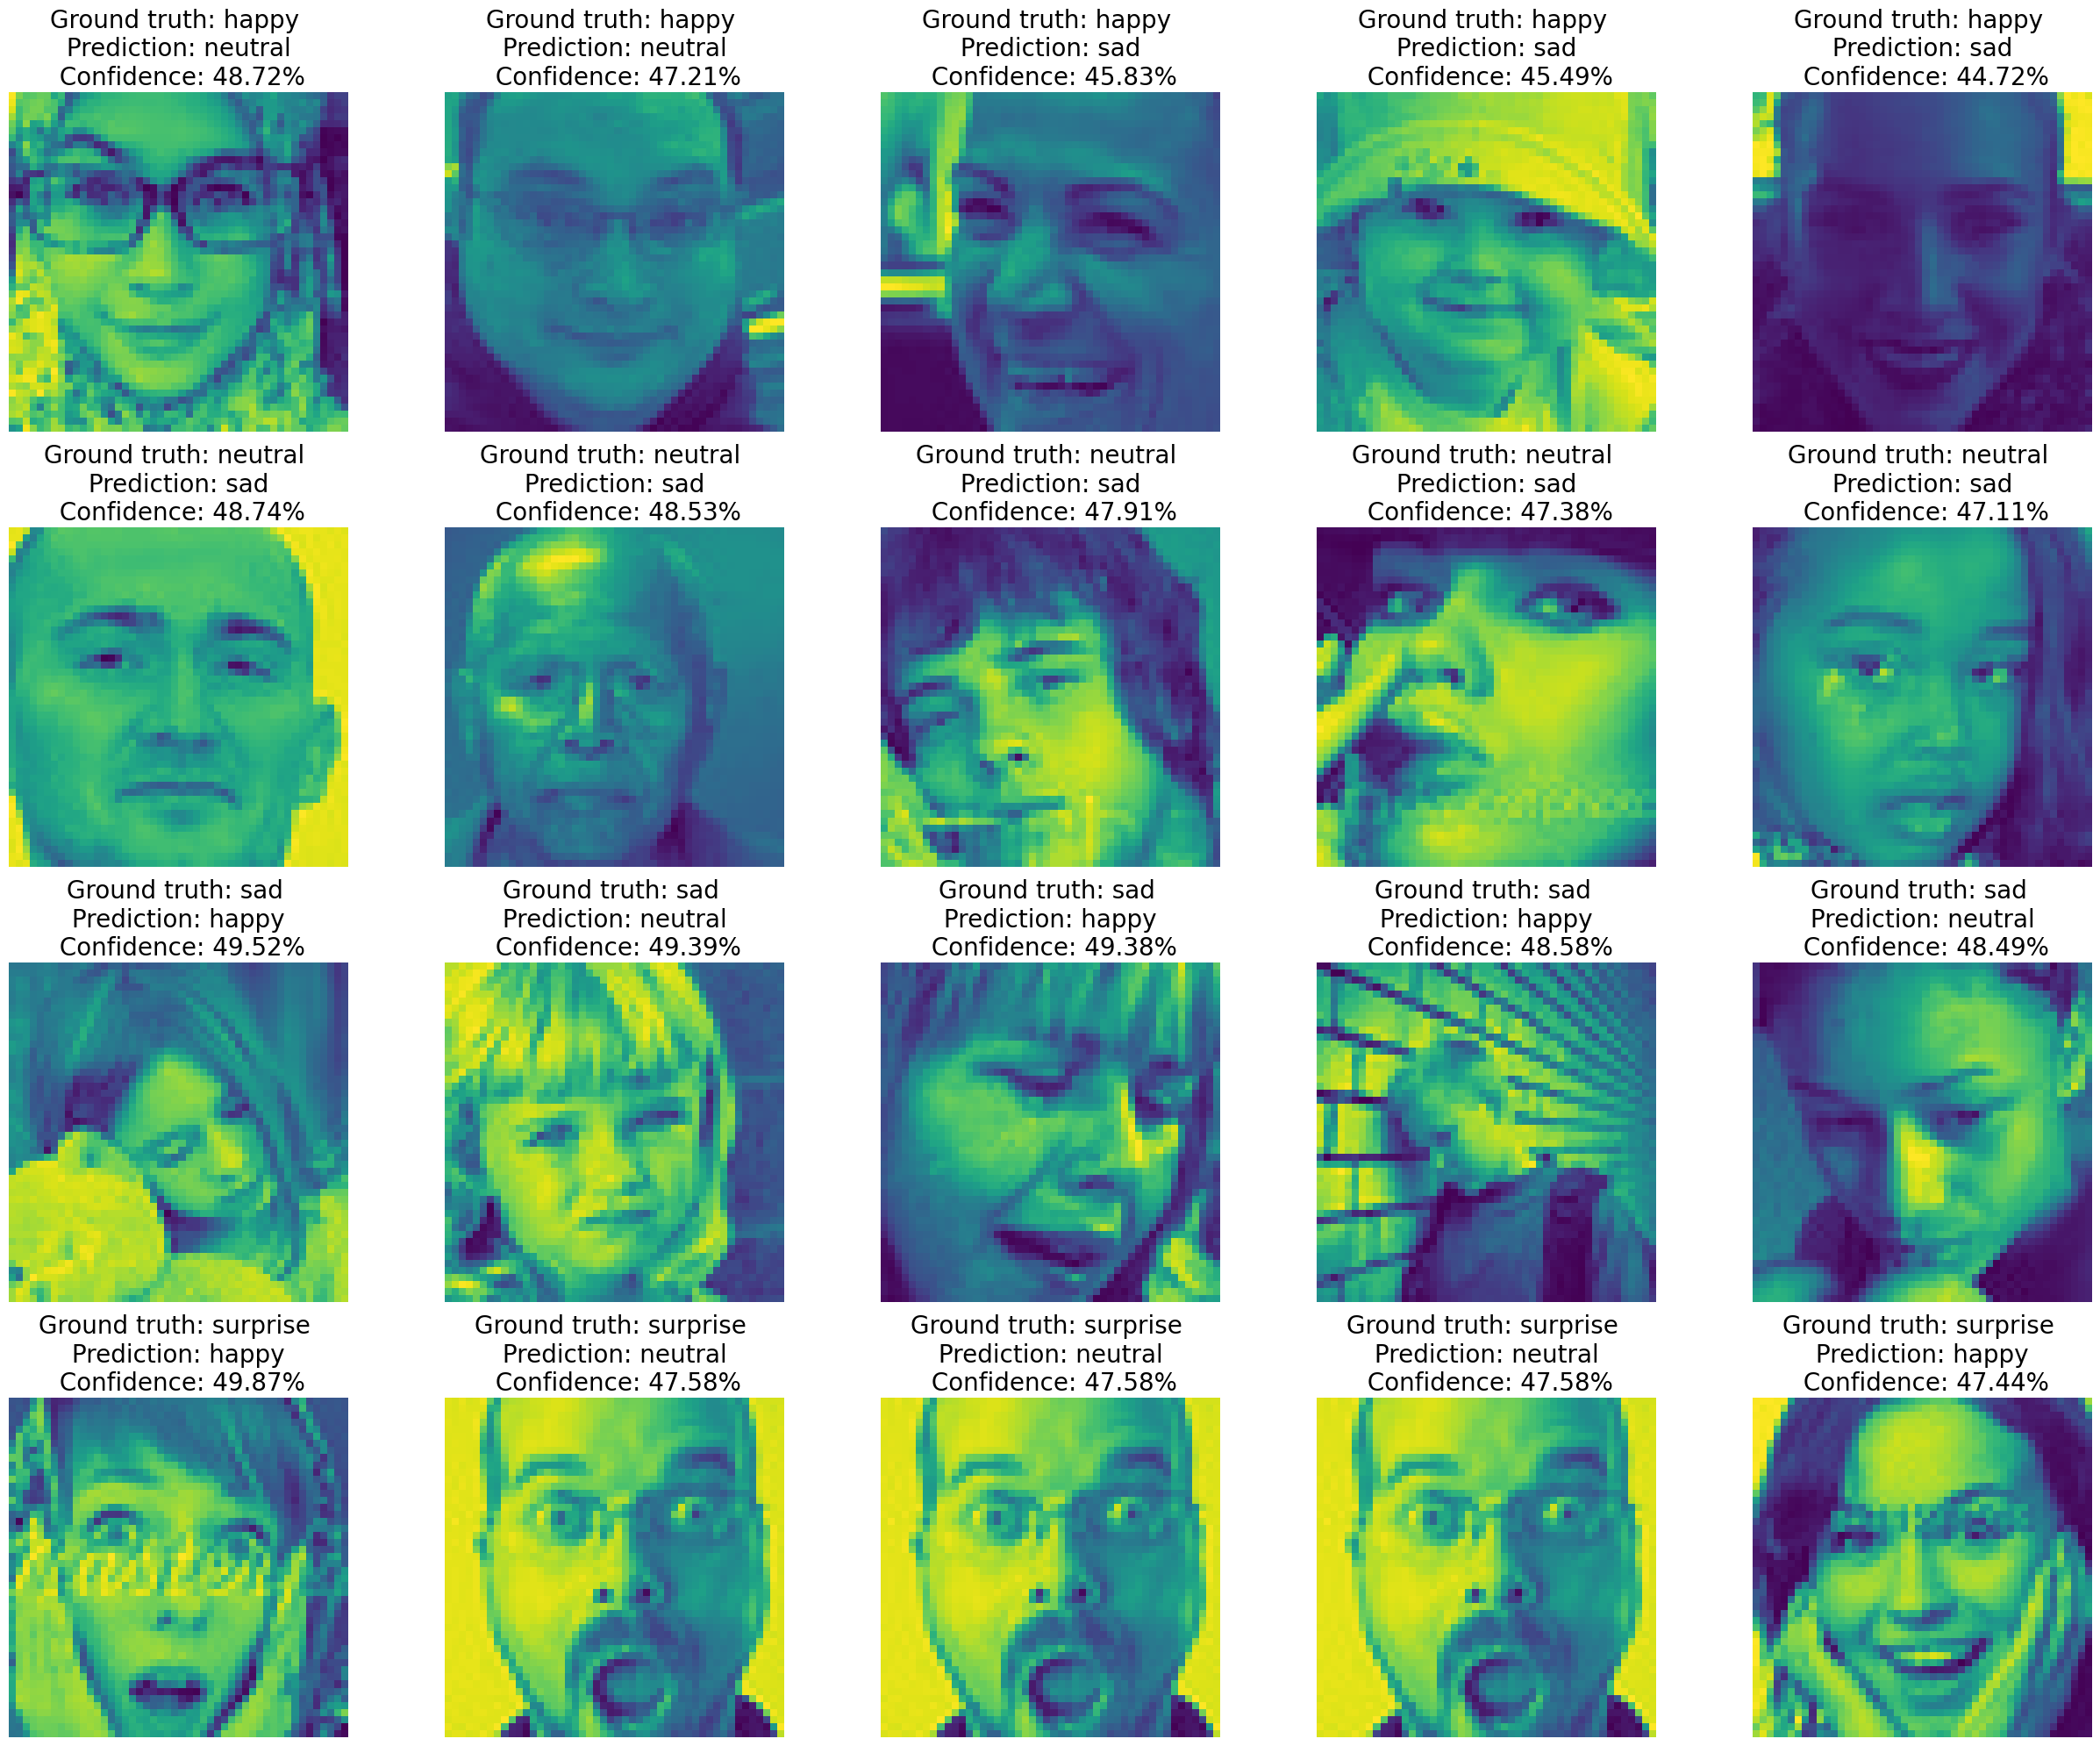

In [35]:
# Loop through each class (category)
num_cols = 5
num_rows = num_classes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, 5*num_rows))
for i in range(num_classes):
    # Get the indices of the images in the current class that were correctly classified
    wrong_indices = (test_labels == i) & (test_preds != i)
    
    # Get the softmax scores for the correctly classified images in the current class
    wrong_scores = torch.softmax(test_outputs[wrong_indices], dim=1)
    
    # Get the top 5 correctly classified images in the current class with the highest softmax scores
    top_wrong_scores, top_wrong_indices = torch.topk(wrong_scores[:, i], k=5)
    top_wrong_images = test_inputs[wrong_indices][top_wrong_indices]
    top_wrong_preds = test_preds[wrong_indices][top_wrong_indices]
    
    # Plot the top 5 correctly classified images from the current class
    for j in range(num_cols):
        ax = axes[i,j]
        ax.axis("off")
        ax.imshow(top_wrong_images[j].permute(1, 2, 0) * 0.5 + 0.5) # un-normalize
        title_text = f"Ground truth: {class_names[i]} \n Prediction: {class_names[top_wrong_preds[j]]} \n Confidence: {top_wrong_scores[j]*100:.2f}%"
        ax.set_title(title_text, fontsize = 20)
plt.tight_layout()
plt.show()

### Saliency Map

Plot a saliency map corresponding to a happy face that was classified correctly

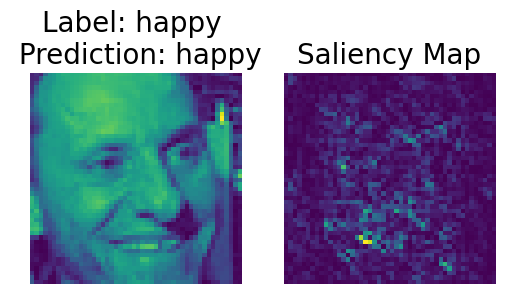

In [36]:
# Find indices of correctly classified test samples
correct_indices = ((test_labels == test_preds) & (test_preds == 0))

# Select a random index from the correctly classified samples
index = np.random.choice(np.where(correct_indices)[0])

# Retrieve the input image, true label, model output, predicted label for the selected index
image = test_inputs[index]
label = test_labels[index]
prediction = test_preds[index]

# Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
image = image.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
# To compute the scores, do a forward pass of the image and then take the argmax
# Use this index to extract the score_max value from "scores"
# Then perform a backward step so that it backpropagates the gradient
scores = task3_model(image)
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]
score_max.backward() # Do the backward step here for the gradient calculation

# Calculate the saliency map by finding the maximum absolute gradient values across channels
# You can use .abs() and torch.max()
grads = image.grad.abs()
saliency_map, _ = torch.max(grads, dim=1)

# Create a subplot to display the original image and saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Display the original image with proper unnormalization
# Do this in the first subplot
axes[0].imshow((image[0].permute(1, 2, 0) * 0.5 + 0.5).detach().numpy()) # un-normalize
axes[0].axis("off")
title_text = f"Label: {class_names[label]} \n Prediction: {class_names[prediction]}"
axes[0].set_title(title_text, fontsize = 20)
# Display the saliency map
# Do this in the second subplot
axes[1].imshow(saliency_map[0].detach().numpy(), vmin=torch.min(saliency_map), vmax=torch.max(saliency_map)) # un-normalize
axes[1].axis("off")
axes[1].set_title("Saliency Map", fontsize = 20)

# Show the original image and saliency map side by side
plt.show()

### My own image

Use an image of yourself being happy - hopefully you are proud of your results! Make sure you output the predicted result

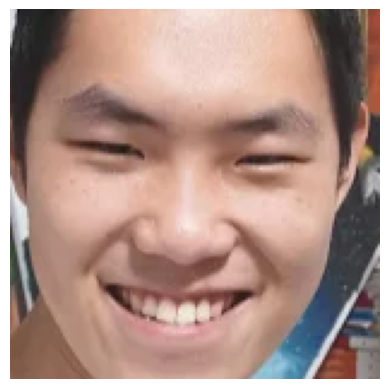

In [49]:
# Read in your image here (we used mpimg.imread and you just need to pass in the path to your image)
# Feel free to use any other image reading functions instead
img = mpimg.imread("alex_happy.png")[:,:,0:3]  # get rid of the 4th axis if exists
plt.imshow(img)
plt.axis('off')
plt.show()


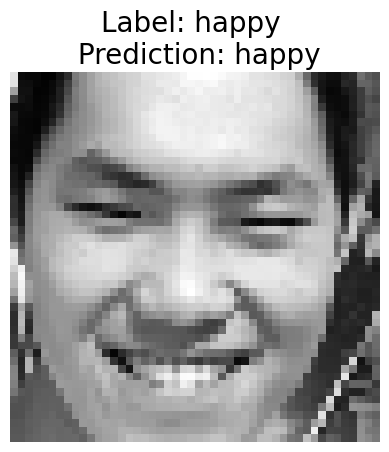

In [50]:
# Pass your image through the network
# Remember to apply the val_test_transforms for your image before doing a forward pass of your model

# apply the val_test_transforms for your image before doing a forward pass of your model
img = val_test_transforms(img)
img = img.unsqueeze(0)
img.requires_grad = False
img = img.to('cpu')
logits = task3_model(img)
prediction = logits.argmax(dim=1)


# plot the image with its prediction
plt.imshow(img[0].squeeze(), cmap='gray')
plt.axis("off")
title_text = f"Label: happy \n Prediction: {class_names[prediction]}"
plt.title(title_text, fontsize = 20)
plt.show()

<div class="alert alert-block alert-success">

## Discussion Questions <a class="anchor" id="t3_1"></a>
    
#### Comment on the resulting confusion matrix.
    
Answer: The model was able to predict happiness and surprise each with good recall and precision, but is less as good at distinguishing neutral and sad. This may be due to neutral expressions and sad expressions looking similar in many cases. 

#### What was the strange thing that you observed in the actual labels when visualizing the misclassified images?
    
Answer: What surprised me was that the actual labels often are completely opposite of what the true emotions are. This is unusual to a human who is able to very easily distinguish emotions. Perhaps the model is simply not rich enough to be able to capture the nuances of facial expressions. Sometimes even when the mouth is curved up and teeth is shown, the eye regions can reveal that the emotion is actually sad. 
    
#### Comment on the saliency map of the 'happy' image.
    
Answer: Most of the focus by the model is on the mouth, and the edge of the mouth in particular. This makes sense, since the mouth and teeth is usually indicative of a smile. 
    
#### Comment on the prediction results of your own data.
    
Answer: My model was able to correctly identify my happiness. 

<div class="alert alert-block alert-danger">

#### This is the end of Notebook II. Hurrah! You have now completed all the Labs for this unit! It's time to reward yourself with an assignment!!!